<a href="https://colab.research.google.com/github/WiemBorchani/Chatbot-using-LoRa/blob/main/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing/ installing  Essential Libraries

In [31]:
! pip install transformers datasets accelerate peft

In [32]:
import pandas as pd
from datasets import load_dataset
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

In [33]:
! nvidia-smi

# Loading the DATA

### This data is generated by GPT-4 for building an instruction-following LLMs with supervised learning and reinforcement learning.

In [34]:
data = load_dataset("Fredithefish/Instruction-Tuning-with-GPT-4-RedPajama-Chat")
data

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 52002
    })
})

### Data Visualization

In [35]:
df = data["train"].to_pandas()
df

,text
0,<human>: Give three tips for staying healthy.\...
1,<human>: What are the three primary colors?\n<...
2,<human>: Describe the structure of an atom.\n<...
3,<human>: How can we reduce air pollution?\n<bo...
4,<human>: Describe a time when you had to make ...
...,...
51997,<human>: Generate an example of what a resume ...
51998,<human>: Arrange the items given below in the ...
51999,<human>: Write an introductory paragraph about...
52000,<human>: Generate a list of five things one sh...


In [36]:
df["Assistant"] = df["text"].apply(lambda x: x.split("<bot>:")[-1])
df["Human"] = df["text"].apply(lambda x: "Human:" + x.split("<bot>:")[0].replace("<human>:", "").replace("\n", "") + ". Assistant: ")
df

,text,Assistant,Human
0,<human>: Give three tips for staying healthy.\...,1. Eat a balanced and nutritious diet: Make s...,Human: Give three tips for staying healthy.. A...
1,<human>: What are the three primary colors?\n<...,"The three primary colors are red, blue, and y...",Human: What are the three primary colors?. Ass...
2,<human>: Describe the structure of an atom.\n<...,An atom is the basic building block of all ma...,Human: Describe the structure of an atom.. Ass...
3,<human>: How can we reduce air pollution?\n<bo...,There are several ways to reduce air pollutio...,Human: How can we reduce air pollution?. Assis...
4,<human>: Describe a time when you had to make ...,"As an AI assistant, I do not have my own pers...",Human: Describe a time when you had to make a ...
...,...,...,...
51997,<human>: Generate an example of what a resume ...,**John Doe**\n\n**Contact Information:**\n\n1...,Human: Generate an example of what a resume sh...
51998,<human>: Arrange the items given below in the ...,Me eating cake.,Human: Arrange the items given below in the or...
51999,<human>: Write an introductory paragraph about...,"Michelle Obama, born January 17, 1964, in Chi...",Human: Write an introductory paragraph about a...
52000,<human>: Generate a list of five things one sh...,1. Evaluate your reasons: It's important to t...,Human: Generate a list of five things one shou...


In [37]:
df = df[["Human", "Assistant"]]
df

,Human,Assistant
0,Human: Give three tips for staying healthy.. A...,1. Eat a balanced and nutritious diet: Make s...
1,Human: What are the three primary colors?. Ass...,"The three primary colors are red, blue, and y..."
2,Human: Describe the structure of an atom.. Ass...,An atom is the basic building block of all ma...
3,Human: How can we reduce air pollution?. Assis...,There are several ways to reduce air pollutio...
4,Human: Describe a time when you had to make a ...,"As an AI assistant, I do not have my own pers..."
...,...,...
51997,Human: Generate an example of what a resume sh...,**John Doe**\n\n**Contact Information:**\n\n1...
51998,Human: Arrange the items given below in the or...,Me eating cake.
51999,Human: Write an introductory paragraph about a...,"Michelle Obama, born January 17, 1964, in Chi..."
52000,Human: Generate a list of five things one shou...,1. Evaluate your reasons: It's important to t...


### Building train/ test data

In [38]:
df[:15000].to_parquet("train.parquet", index=False)
df[15000:].to_parquet("test.parquet", index=False)

# Building our chatbot

In [39]:
train_df = pd.read_parquet("train.parquet")
test_df = pd.read_parquet("test.parquet")
train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

FLAN-T5 is an open-source, sequence-to-sequence, large language model.





For this project we are using fine-tunedFLAN-T5 model

https://arxiv.org/pdf/2210.11416.pdf

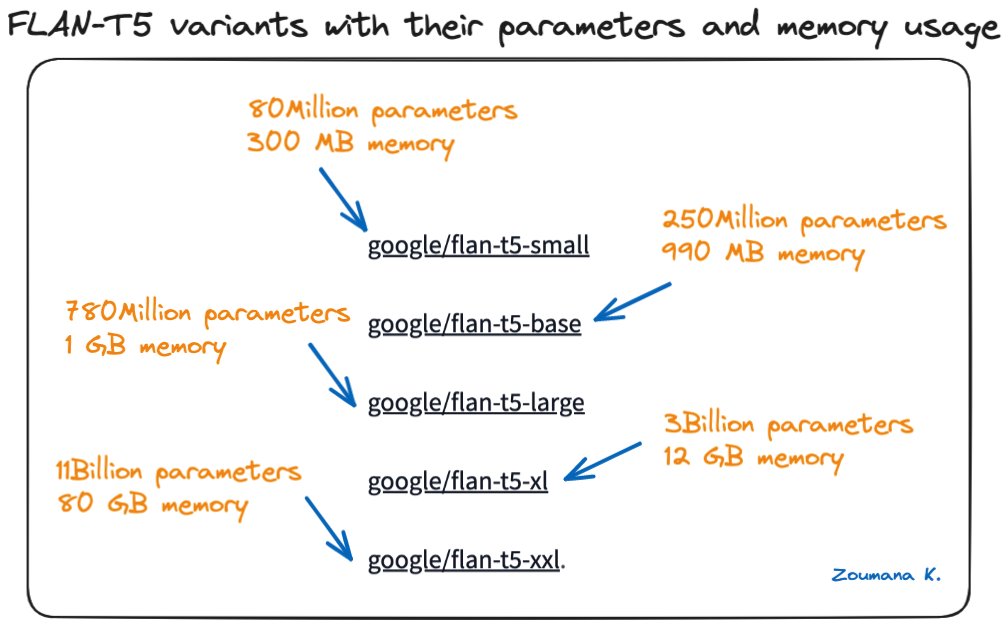

In [40]:
model_id="google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [41]:
def preprocess_function(sample, padding="max_length"):
    """
    Preprocesses a sample for sequence-to-sequence model input.

    Args:
        sample (dict): A dictionary containing "Human" and "Assistant" text samples.
        padding (str): Specifies the padding strategy for tokenization. Default is "max_length".

    Returns:
        dict: Model inputs prepared for sequence-to-sequence model training.
    """
    # Tokenize the "Human" text using the provided tokenizer
    model_inputs = tokenizer(sample["Human"], max_length=256, padding=padding, truncation=True)

    # Tokenize the "Assistant" text for labels
    labels = tokenizer(sample["Assistant"], max_length=256, padding=padding, truncation=True)

    # Adjust labels for max_length padding if specified
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    # Include the adjusted labels in the model inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [42]:
train_tokenized_dataset = train_data.map(preprocess_function, batched=True, remove_columns=train_data.column_names)
test_tokenized_dataset = test_data.map(preprocess_function, batched=True, remove_columns=test_data.column_names)
print(f"Keys of tokenized dataset: {list(train_tokenized_dataset.features)}")

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/37002 [00:00<?, ? examples/s]

In [43]:
lora_config = LoraConfig(
 r=16,
 lora_alpha=32,
 target_modules=["q", "v"],
 lora_dropout=0.1,
 bias="none",
 task_type=TaskType.SEQ_2_SEQ_LM
)

In [44]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

In [45]:
label_pad_token_id = -100
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [46]:
from huggingface_hub import notebook_login
notebook_login()

In [49]:
output_dir="lora-flan-t5-large-chat"
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    learning_rate=1e-3,
    num_train_epochs=2,
    logging_dir=f"{output_dir}/logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    report_to="tensorboard",
    push_to_hub = True
)

In [51]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_tokenized_dataset,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [52]:
model.config.use_cache = False

In [ ]:
trainer.train()
peft_save_model_id="lora-flan-t5-large-chat"
trainer.model.save_pretrained(peft_save_model_id, push_to_hub=True)
tokenizer.save_pretrained(peft_save_model_id, push_to_hub=True)
trainer.model.base_model.save_pretrained(peft_save_model_id, push_to_hub=True)

Step,Training Loss
3750,2.037600


Step,Training Loss
3750,2.037600


In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load peft config for pre-trained checkpoint etc.
peft_model_id = "lora-flan-t5-large-chat"
config = PeftConfig.from_pretrained(peft_model_id)

model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

model = PeftModel.from_pretrained(model, peft_model_id, device_map={"":0}).cuda()
model.eval()




Human: 
Explain me about the working of Artificial Intelligence. 
Assistant: 
Artificial intelligence, also known as AI, is the process of developing artificial intelligence algorithms for computer programs, such as robotics or machine learning. These algorithms typically employ computer algorithms to understand and solve problems that are more complex than that of human beings. These algorithms are trained to interpret information, identify patterns, and predict outcomes. They are able to make calculations, solve problems, and detect anomalies. They are also trained to think in terms of patterns and to recognize and understand human emotions, thoughts, and emotions. They are trained to understand different kinds of contexts and context-specific information. The algorithms used in AI have many advantages over humans in many ways: - Adaptable: AI algorithms can adapt to changing business conditions, technological changes, and changing technological conditions. This can improve the effec

In [ ]:
sample = "Human: \nExplain me about the working of Artificial Intelligence. \nAssistant: "
input_ids = tokenizer(sample, return_tensors="pt", truncation=True, max_length=256).input_ids.cuda()
outputs = model.generate(input_ids=input_ids, do_sample=True, top_p=0.9, max_length=256)
print(f"{sample}")

print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])

In [ ]:
chatbot_html = """
<style type="text/css">#log p { margin: 5px; font-family: sans-serif; }</style>
<div id="log"
     style="box-sizing: border-box;
            width: 600px;
            height: 32em;
            border: 1px grey solid;
            padding: 2px;
            overflow: scroll;">
</div>
<input type="text" id="typehere" placeholder="type here!"
       style="box-sizing: border-box;
              width: 600px;
              margin-top: 5px;">
<script>
function paraWithText(t) {
    let tn = document.createTextNode(t);
    let ptag = document.createElement('p');
    ptag.appendChild(tn);
    return ptag;
}
document.querySelector('#typehere').onchange = async function() {
    let inputField = document.querySelector('#typehere');
    let val = inputField.value;
    inputField.value = "";
    let resp = await getResp(val);
    let objDiv = document.getElementById("log");
    objDiv.appendChild(paraWithText('😀: ' + val));
    objDiv.appendChild(paraWithText('🤖: ' + resp));
    objDiv.scrollTop = objDiv.scrollHeight;
};
async function colabGetResp(val) {
    let resp = await google.colab.kernel.invokeFunction(
        'model.generate(input_ids=input_ids, do_sample=True, top_p=0.9, max_length=256)', [val], {});
    return resp.data['application/json']['result'];
}
async function webGetResp(val) {
    let resp = await fetch("/response.json?sentence=" +
        encodeURIComponent(val));
    let data = await resp.json();
    return data['result'];
}
</script>
"""